In [16]:
import numpy as np
import scipy as sp 
from matplotlib import pyplot as plt

In [35]:
# define relevant constants
n = 1000
sigma = np.sqrt(sigma_2)
m = 9
k = 10

In [36]:
#helpful functions!
def designmatrix(x_input,m):
    X = np.vstack([np.ones(np.size(x_input))]).T
    for i in range(m):
        X = np.vstack([X.T, x_input**(i+1)]).T
    return X
def designvector(x_input,m):
    dvector = np.vstack([1]).T
    for i in range(m):
        dvector = np.vstack([dvector.T, x_input**(i+1)]).T
    return dvector

In [37]:
# generate sample data 
noise = np.random.normal(0,sigma,n)
x = np.random.uniform(-1,1,size=n)
y = np.sin(2*np.pi*x) + noise

In [38]:
#generate matrices containing bias functions, variance functions, and MSE
avg_bias_2, avg_variance, avg_testMSE= np.zeros(m),  np.zeros(m),  np.zeros(m)

for p in range(m):
    testMSE = np.zeros(k)
    
    X = designmatrix(x, p+1)
    
    #iterate over the k-fold set
    for i in range(k):
        
        #split data using k-blocks, taking the i-th for testing and the rest for training.
        x_train = np.concatenate((x[0:100*i], x[100*(i+1):1000]))
        y_train = np.concatenate((y[0:100*i], y[100*(i+1):1000]))
        x_test = x[100*i:100*(i+1)]
        y_test = y[100*i:100*(i+1)]
        
        #design matrices
        X_train = designmatrix(x_train, p+1)
        X_test = designmatrix(x_test, p+1)
        
        #compute coefficients
        w = np.linalg.lstsq(X_train,y_train, rcond=None)[0]
        
        #store coefficients
        if (i == 0):
            mw = w
        else:
            mw = np.vstack([mw.T, w]).T
        
        #compute MSE
        testMSE[i] = (1 / len(x_test)) * (y_test - X_test @ w).T @ (y_test - X_test @ w)
    
    #values on which we evaluate each model, the average model, and the true underlying model (w/o noise)
    values = np.linspace(-1,1,50)
    testmatrix = designmatrix(values, p+1) #design matrix for these values
    
    #compute fold-averaged bias using formula
    average_model = np.average(mw,axis=1)
    avg_bias_2[p] = (1 / len(values)) * sum((testmatrix @ average_model - np.sin(2*np.pi*values))**2)
    
    #compute fold-averaged variance using double-sum formula
    variance = 0
    values = np.linspace(-1,1,50)
    for x_value in values:
        inner = 0
        for model_index in range(k): 
            inner = inner + (designvector(x_value, p+1) @ mw[:,model_index] - designvector(x_value, p+1) @ average_model)**2
        variance = variance + inner 
    avg_variance[p] = variance / k
    
    #compute fold-averaged MSE values  
    avg_testMSE[p] = np.average(testMSE)


/var/folders/6_/478gy13932n5hyzwyl7crpwm0000gn/T/ipykernel_37426/1696881217.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  avg_variance[p] = variance / k


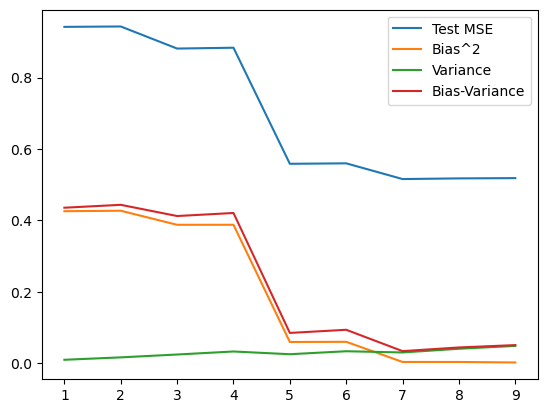

In [41]:
#plot bias^2, variance, bias^2 + variance, and test MSE
x_axis = list(range(1,m+1))

#
plt.plot(x_axis, avg_testMSE, label='Test MSE')
plt.plot(x_axis, avg_bias_2, label='Bias^2')
plt.plot(x_axis, avg_variance, label='Variance')
plt.plot(x_axis, avg_bias_2 + avg_variance, label='Bias-Variance')
#plt.yscale("log")

plt.legend()

In [57]:
r_avg_bias_2, r_avg_variance, r_avg_testMSE= np.zeros(number),  np.zeros(number),  np.zeros(number)

order = 7
number = 500
lmbdarange = np.linspace(0,2.7,number)

for index in range(number):
    testMSE = np.zeros(k)
    
    X = designmatrix(x, order)
    
    #iterate over the k-fold set
    for i in range(k):
        
        #split data using k-blocks, taking the i-th for testing and the rest for training.
        x_train = np.concatenate((x[0:100*i], x[100*(i+1):1000]))
        y_train = np.concatenate((y[0:100*i], y[100*(i+1):1000]))
        x_test = x[100*i:100*(i+1)]
        y_test = y[100*i:100*(i+1)]
        
        #design matrices
        X_train = designmatrix(x_train, order)
        X_test = designmatrix(x_test, order)
        
        #compute coefficients
        w = np.linalg.inv(X_train.T @ X_train + lmbdarange[index] * np.identity(order + 1)) @ X_train.T @ y_train
        
        #store coefficients
        if (i == 0):
            mw = w
        else:
            mw = np.vstack([mw.T, w]).T
        
        #compute MSE
        testMSE[i] = (1 / len(x_test)) * (y_test - X_test @ w).T @ (y_test - X_test @ w)
    
    #values on which we evaluate each model, the average model, and the true underlying model (w/o noise)
    values = np.linspace(-1,1,50)
    testmatrix = designmatrix(values, order) #design matrix for these values
    
    #compute bias using formula
    average_model = np.average(mw,axis=1)
    r_avg_bias_2[index] = (1 / len(values)) * sum((testmatrix @ average_model - np.sin(2*np.pi*values))**2)
    
    #compute variance using double-sum formula
    variance = 0
    values = np.linspace(-1,1,50)
    for x_value in values:
        inner = 0
        for model_index in range(k): 
            inner = inner + (designvector(x_value, order) @ mw[:,model_index] - designvector(x_value, order) @ average_model)**2
        variance = variance + inner 
    r_avg_variance[index] = variance / k
    
    r_avg_testMSE[index] = np.average(testMSE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/6_/478gy13932n5hyzwyl7crpwm0000gn/T/ipykernel_37426/3506593171.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_avg_variance[index] = variance / k


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/6_/478gy13932n5hyzwyl7crpwm0000gn/T/ipykernel_37426/2144493721.py:1: RuntimeWarning: divide by zero encountered in log
  x_axis = np.log(lmbdarange)


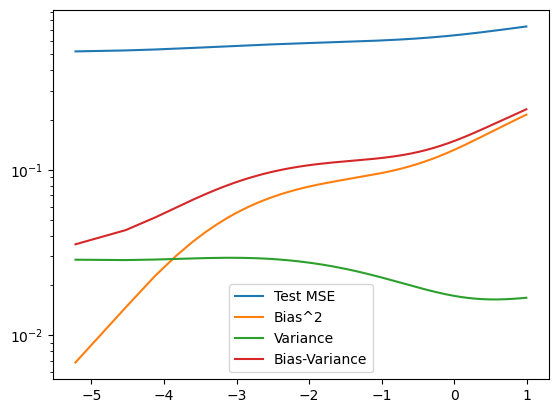

In [58]:
x_axis = np.log(lmbdarange)

plt.plot(x_axis, r_avg_testMSE, label='Test MSE')
plt.plot(x_axis, r_avg_bias_2, label='Bias^2')
plt.plot(x_axis, r_avg_variance, label='Variance')
plt.plot(x_axis, r_avg_bias_2 + r_avg_variance, label='Bias-Variance')
plt.yscale("log")

plt.legend()